# Библиотеки

In [84]:
pip install pandahouse

Note: you may need to restart the kernel to use updated packages.


In [85]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [86]:
pip install tfcausalimpact

Note: you may need to restart the kernel to use updated packages.


In [87]:
import pandas as pd
import pandahouse as ph
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

# Задание 1

Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2025-01-17 по 2025-01-23. Ваша задача как аналитика – оценить эффективность этого мероприятия.

выгрузим данные, уже с необходимыми нам метриками, на которые мы хотим посмотреть

In [88]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'}

In [89]:
q = '''
SELECT 
    toDate(time) AS date,
    COUNT(post_id) AS count_of_posts,
    COUNT(DISTINCT user_id) AS users_DAU,
    countIf(action = 'view') AS views,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM {db}.feed_actions 
GROUP BY date
ORDER BY 
    date
'''

In [90]:
df = ph.read_clickhouse(q, connection=connection)
df.set_index('date', inplace = True, drop = True)
df.head()

,count_of_posts,users_DAU,views,CTR
date,,,,
2024-12-07,9163,878,7603,0.205182
2024-12-08,75586,2238,62770,0.204174
2024-12-09,126484,3105,105526,0.198605
2024-12-10,142796,3721,118996,0.200007
2024-12-11,208958,4617,174454,0.197783


# 1.8  DAU

Определим даты для пре-периода и пост-периода.

In [91]:
pre_period = [pd.Timestamp('2024-12-07'),pd.Timestamp('2025-01-16')]

In [92]:
post_period = [pd.Timestamp('2025-01-17'),pd.Timestamp('2025-01-24')]

Запустим нашу модель и посмотри на результаты.

In [93]:
dau_impact = CausalImpact(pd.Series(df.users_DAU), pre_period, post_period)

In [94]:
print(dau_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16070.5            128564.0
Prediction (s.d.)         15033.16 (1112.87) 120265.3 (8902.94)
95% CI                    [12916.6, 17278.96][103332.8, 138231.67]

Absolute effect (s.d.)    1037.34 (1112.87)  8298.7 (8902.94)
95% CI                    [-1208.46, 3153.9] [-9667.67, 25231.2]

Relative effect (s.d.)    6.9% (7.4%)        6.9% (7.4%)
95% CI                    [-8.04%, 20.98%]   [-8.04%, 20.98%]

Posterior tail-area probability p: 0.19
Posterior prob. of a causal effect: 81.42%

For more details run the command: print(impact.summary('report'))


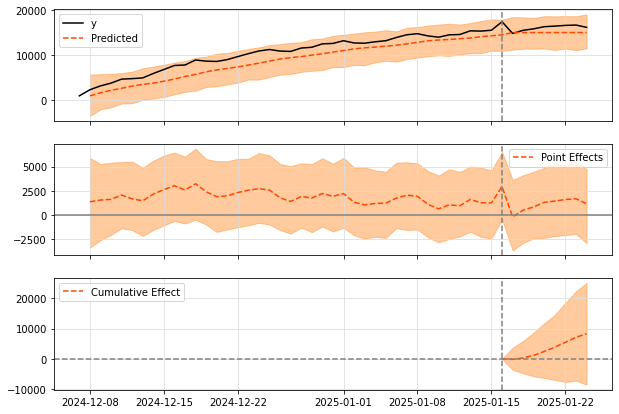

In [95]:
dau_impact.plot()

DAU значимо не изменилось. Средняя величина абсолютного эффекта - примерно 1000

# CTR

Определим даты для пре-периода и пост-периода

In [96]:
CTR_impact = CausalImpact(pd.Series(df.CTR), pre_period, post_period)

Запустим нашу модель и посмотри на результаты

In [97]:
print(CTR_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.7
Prediction (s.d.)         0.21 (0.0)         1.66 (0.02)
95% CI                    [0.2, 0.21]        [1.63, 1.69]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    2.83% (0.93%)      2.83% (0.93%)
95% CI                    [1.04%, 4.7%]      [1.04%, 4.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


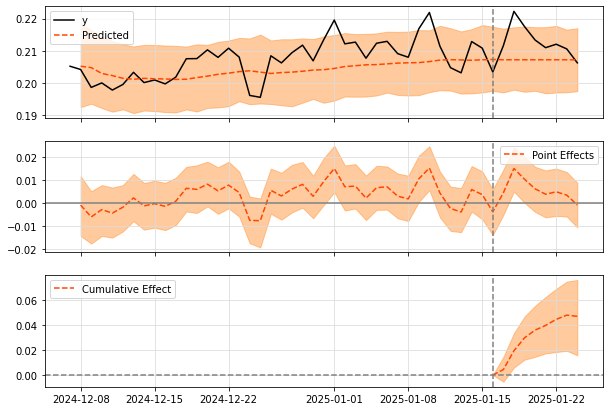

In [98]:
CTR_impact.plot()

CTR значимо, но незначительно вырос. Средняя величина абсолютного эффекта - примерно 0.01.

# Просмотры

Определим даты для пре-периода и пост-периода

In [99]:
views_impact = CausalImpact(pd.Series(df.views), pre_period, post_period)

Запустим нашу модель и посмотри на результаты

In [100]:
print(views_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1030725.5          8245804.0
Prediction (s.d.)         363840.34 (48737.74)2910722.75 (389901.96)
95% CI                    [270353.05, 461401.54][2162824.42, 3691212.32]

Absolute effect (s.d.)    666885.12 (48737.74)5335081.0 (389901.96)
95% CI                    [569323.96, 760372.45][4554591.68, 6082979.58]

Relative effect (s.d.)    183.29% (13.4%)    183.29% (13.4%)
95% CI                    [156.48%, 208.99%] [156.48%, 208.99%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


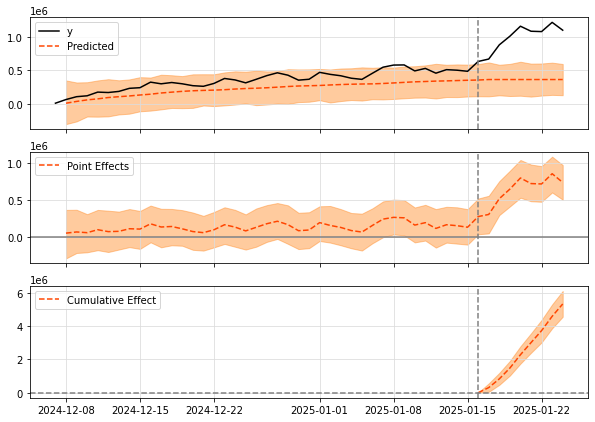

In [101]:
views_impact.plot()

Число просмотров значимо выросло. Средняя величина абсолютного эффекта - примерно 666 885.

# Число новых постов

Извлечем необходимые нам данные

In [109]:
q2 = '''
SELECT 
    publish_date AS date,
    COUNT(DISTINCT post_id) AS new_posts
FROM (
    -- Определяем дату первой активности (публикации) для каждого поста
    SELECT 
        post_id, 
        MIN(toDate(time)) AS publish_date
    FROM {db}.feed_actions
    WHERE action = 'view'  -- Учитываем только просмотры как первую активность
    GROUP BY post_id
) AS post_first_dates
GROUP BY publish_date
ORDER BY publish_date;
'''

In [110]:
new_posts = ph.read_clickhouse(q2, connection=connection)
new_posts.set_index('date', inplace = True, drop = True)
new_posts 

Определим даты для пре-периода и пост-периода

In [113]:
new_posts_impact = CausalImpact(pd.Series(new_posts.new_posts), pre_period, post_period)

Запустим нашу модель и посмотри на результаты

In [114]:
print(new_posts_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    76.75              614.0
Prediction (s.d.)         72.02 (4.54)       576.14 (36.3)
95% CI                    [63.59, 81.37]     [508.7, 650.98]

Absolute effect (s.d.)    4.73 (4.54)        37.86 (36.3)
95% CI                    [-4.62, 13.16]     [-36.98, 105.3]

Relative effect (s.d.)    6.57% (6.3%)       6.57% (6.3%)
95% CI                    [-6.42%, 18.28%]   [-6.42%, 18.28%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 85.21%

For more details run the command: print(impact.summary('report'))


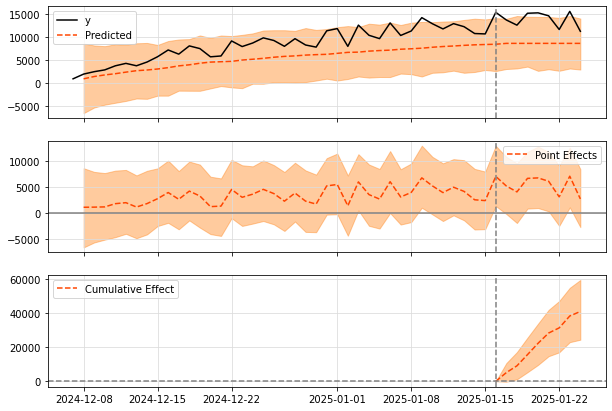

In [108]:
new_posts_impact.plot()

Число новых постов значимо не изменилось. Средняя величина абсолютного эффекта - примерно 5.

#  Число уникальных просматриваемых постов

Извлечем необходимые нам данные

In [115]:
q3 = '''
SELECT 
    toDate(time) AS date,
    COUNT(DISTINCT post_id) AS unique_viewed_posts
FROM {db}.feed_actions
WHERE action = 'view'
GROUP BY date
ORDER BY date;
'''

In [117]:
unique_posts = ph.read_clickhouse(q3, connection=connection)
unique_posts.set_index('date', inplace = True, drop = True)
unique_posts

,unique_viewed_posts
date,
2024-12-07,89
2024-12-08,178
2024-12-09,191
2024-12-10,211
2024-12-11,214
...,...
2025-02-09,200
2025-02-10,200
2025-02-11,213


Определим даты для пре-периода и пост-периода

In [119]:
unique_posts_impact = CausalImpact(pd.Series(unique_posts.unique_viewed_posts), pre_period, post_period)

Запустим нашу модель и посмотри на результаты

In [120]:
print(unique_posts_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    281.62             2253.0
Prediction (s.d.)         197.33 (8.61)      1578.66 (68.88)
95% CI                    [179.6, 213.35]    [1436.83, 1706.83]

Absolute effect (s.d.)    84.29 (8.61)       674.34 (68.88)
95% CI                    [68.27, 102.02]    [546.17, 816.17]

Relative effect (s.d.)    42.72% (4.36%)     42.72% (4.36%)
95% CI                    [34.6%, 51.7%]     [34.6%, 51.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


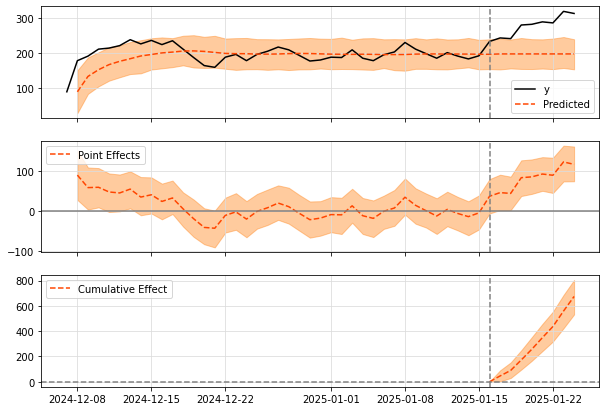

In [121]:
unique_posts_impact.plot()

Число уникальных просматриваемых постов значимо выросло. Средняя величина абсолютного эффекта - примерно 84.